# Assignment 4 – Machine Learning Fashionista
`SVC` | `PCA` | `LDA` 

### 1. Problem Definition

### 2. Library Importation

In [1]:
!pip install python-resize-image

In [2]:
from glob import glob
from PIL import Image
from resizeimage import resizeimage
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt

### 3. Loading & preprocessing the images

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
dir_path = '/content/gdrive/MyDrive/Colab Notebooks/CS156'

In [5]:
clothing_classes = ['jerseys','shirts']

#Dictionary to store the images for the two different classes
img_data = {}

#List to store all the flattened images – for all classes
flattened_imgs = []

#Size to resize images to
img_size = [400,400]

for clothing_class in enumerate(clothing_classes):
    
    #Create path for the image class of interest
    class_imgs = glob(f'{dir_path}/{clothing_class[1]}/*.JPEG')
    
    #For each image path
    for path in class_imgs[:250]:
        
        #Open it as a read file in binary mode
        with open(path, 'r+b') as f:
            
            #Open it as an image
            with Image.open(f) as image:
                
                #Check if the image is too small
                if min(image.size) < min(img_size):
                    
                    #If it is, enlarge to the img_size
                    cover = image.resize(img_size)
                    
                else:
                    #Resize the image to be more manageable
                    cover = resizeimage.resize_cover(image, img_size)
                    
                #Flatten the matrix to an array and append it to all flattened images list
                flattened_imgs.append((np.array(cover).flatten(),clothing_class[0]))
         
#Flatten once more
flattened_imgs = np.asarray(flattened_imgs)

#Make a copy of the array to shuffle
flattened_and_shuffled = flattened_imgs.copy()

#Shuffle the array containing all the images and their labels
np.random.default_rng().shuffle(flattened_and_shuffled)
    
#Split into images and labels
X = np.stack(i for i in flattened_and_shuffled[:,0])
Y = np.stack(i for i in flattened_and_shuffled[:,1])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


### 4. Data Exploration
`Visualizing some of the images`

**Jerseys**

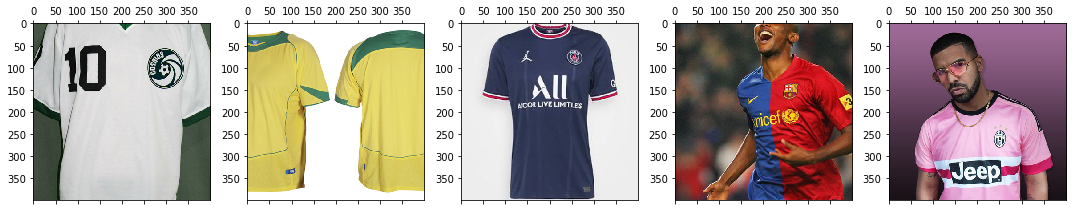

In [7]:
plt.figure(figsize=(15,15))
for idx,img in enumerate(np.random.choice(250,5)):
    plt.subplot(1,5,idx+1).matshow(flattened_imgs[img,0].reshape((400,400,3)))
plt.tight_layout()
plt.show()

**Shirts (i.e. Non-jerseys)**

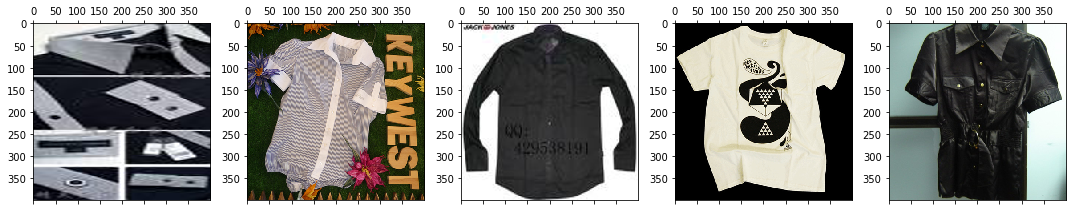

In [12]:
plt.figure(figsize=(15,15))
for idx,img in enumerate(np.random.choice(range(251,len(X)),5)):
    plt.subplot(1,5,idx+1).matshow(flattened_imgs[img,0].reshape((400,400,3)))

plt.tight_layout()
plt.show()

### 5. Splitting the data into train and test
Split dataset into 80% training data and 20% testing data.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20)

In [16]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([204, 196]))

### 6. Modeling: Linear SVC

In [17]:
#Perform a grid search to determine the optimal C value for linear SVC
clf = GridSearchCV(estimator = SVC(kernel='linear'),
                   param_grid = {'C': [0.1, 1, 10]},
                   cv=3, verbose = 2, n_jobs = -1)

#Fit on the original data
clf.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  7.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1, param_grid={'C': [0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [18]:
#Display the best estimator from the grid search
clf.best_estimator_

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### a. Computing error rate

**Training set**

In [19]:
#Compute error rate for training data with best estimator
train_acc_score = clf.best_estimator_.score(X_train,y_train)
train_error = 1 - train_acc_score
print(f"Training set error rate: {train_error}")

Training set error rate: 0.0


**Test set**

In [20]:
#Compute error rate for test data
test_acc_score = clf.best_estimator_.score(X_test,y_test)
test_error = 1 - test_acc_score
print(f"Test set error rate: {test_error}")

Test set error rate: 0.24


We see evidence of overfitting in the model above – we get perfect accuracy (i.e. 0% error rate) on the training set, but have significant error (24%) when predicting on the test set.

### b. Classification report & confusion matrix
`Test set`

In [21]:
#Predict on the test data
y_preds = clf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_preds,target_names=['jerseys','shirts']))

              precision    recall  f1-score   support

     jerseys       0.76      0.70      0.73        46
      shirts       0.76      0.81      0.79        54

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100



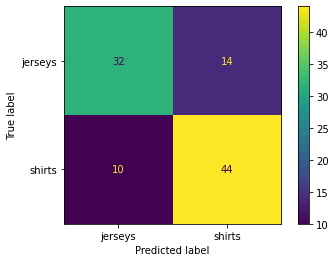

In [22]:
plot_confusion_matrix(clf.best_estimator_, X_test, y_test,display_labels=['jerseys','shirts'])  
plt.show() 

### 7. Modeling: PCA + Linear SVC

In [23]:
#Note steps – these will be used in the creation of a pipeline
estimators = [('reduce_dim', PCA()), 
              ('clf', clf.best_estimator_)]

#Create pipeline
pipe = Pipeline(estimators)

#Create parameter list for optimization trial
params = {'reduce_dim__n_components': [2, 5]}

#Run grid search to find best parameters given the training data
pca_svc_gs = GridSearchCV(pipe, param_grid = params, 
                          cv=2, verbose=2)

pca_svc_gs.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] reduce_dim__n_components=2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... reduce_dim__n_components=2, total= 1.3min
[CV] reduce_dim__n_components=2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ....................... reduce_dim__n_components=2, total= 1.8min
[CV] reduce_dim__n_components=5 ......................................
[CV] ....................... reduce_dim__n_components=5, total= 2.6min
[CV] reduce_dim__n_components=5 ......................................
[CV] ....................... reduce_dim__n_components=5, total= 6.6min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 12.2min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('reduce_dim',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        SVC(C=0.1, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='linear', max_iter=-1,
                                            probability=False

**Note:** Ideally, I would feed in different values of C for the linear SVC in the code cell above, in order to try to optimize the model. However, the GridSearchCV for the linear SVC only (Section 6) took quite some time. I instead opted to use the best SVC model from Section 6's optimization to save time.

### a. Computing error rate

**Training set**

In [24]:
#Compute error rate for training data with best estimator
pca_svc_train_acc_score = pca_svc_gs.best_estimator_.score(X_train,y_train)
pca_svc_train_error = 1 - pca_svc_train_acc_score
print(f"Training set error rate (PCA + SVC): {pca_svc_train_error}")

Training set error rate (PCA + SVC): 0.3025


**Test set**

In [25]:
#Compute error rate for training data with best estimator
pca_svc_test_acc_score = pca_svc_gs.best_estimator_.score(X_test,y_test)
pca_svc_test_error = 1 - pca_svc_test_acc_score
print(f"Test set error rate (PCA + SVC): {pca_svc_test_error}")

Test set error rate (PCA + SVC): 0.22999999999999998


Doesn't appear to overfit like the last model – might be underfitting instead. Performed better on the test set than the training set.

### b. Classification report & confusion matrix
`Test set`

In [26]:
#Predict on the test data
pca_svc_y_preds = pca_svc_gs.best_estimator_.predict(X_test)
print(classification_report(y_test, pca_svc_y_preds,target_names=['jerseys','shirts']))

              precision    recall  f1-score   support

     jerseys       0.70      0.87      0.78        46
      shirts       0.86      0.69      0.76        54

    accuracy                           0.77       100
   macro avg       0.78      0.78      0.77       100
weighted avg       0.79      0.77      0.77       100



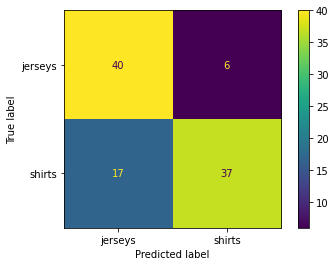

In [27]:
plot_confusion_matrix(pca_svc_gs.best_estimator_, X_test, y_test,display_labels=['jerseys','shirts'])  
plt.show() 

The model does pretty well at accurately predicting shirts. But predicts a significant number of jerseys as shirts

### 8. Modeling: LDA + Linear SVC

In [ ]:
#Note steps – these will be used in the creation of a pipeline
lda_svc_estimators = [('LDA', LinearDiscriminantAnalysis()), 
                      ('clf', clf.best_estimator_)]

#Create pipeline
lda_svc_pipe = Pipeline(lda_svc_estimators)

#Create parameter list for optimization trial
lda_svc_params = {'LDA__solver': ['svd', 'lsqr', 'eigen']}

#Run grid search to find best parameters given the training data
lda_svc_gs = GridSearchCV(lda_svc_pipe, 
                          param_grid = lda_svc_params, 
                          cv=2, verbose=2)

lda_svc_gs.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] LDA__solver=svd .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. LDA__solver=svd, total=  53.5s
[CV] LDA__solver=svd .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.5s remaining:    0.0s


[CV] .................................. LDA__solver=svd, total=  51.7s
[CV] LDA__solver=lsqr ................................................


### a. Computing error rate

**Training set**

In [ ]:
#Compute error rate for training data with best estimator
lda_svc_train_acc_score = lda_svc_gs.best_estimator_.score(X_train,y_train)
lda_svc_train_error = 1 - lda_svc_train_acc_score
print(f"Training set error rate (LDA + SVC): {lda_svc_train_error}")

**Test set**

In [ ]:
#Compute error rate for training data with best estimator
lda_svc_test_acc_score = lda_svc_gs.best_estimator_.score(X_test,y_test)
lda_svc_test_error = 1 - lda_svc_test_acc_score
print(f"Test set error rate (LDA + SVC): {lda_svc_test_error}")

### b. Classification report & confusion matrix
`Test set`

In [ ]:
#Predict on the test data
lda_svc_y_preds = lda_svc_gs.best_estimator_.predict(X_test)
print(classification_report(y_test, lda_svc_y_preds,target_names=['jerseys','shirts']))

In [ ]:
plot_confusion_matrix(lda_svc_gs.best_estimator_, X_test, y_test,display_labels=['jerseys','shirts'])  
plt.show() 